## Importando Recursos


In [ ]:
# !pip install --quiet --upgrade tensorflow-federated

In [ ]:
import tensorflow_federated as tff
import kagglehub
from os import path
from kagglehub import KaggleDatasetAdapter
import pandas as pd
import os
import plotly.express as px
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, Reshape
from tensorflow.keras.optimizers import SGD
from tensorflow.data import Dataset
import dp_accounting
import seaborn as sns

ERROR:jax._src.xla_bridge:Jax plugin configuration error: Plugin module %s could not be loaded
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/jax/_src/xla_bridge.py", line 428, in discover_pjrt_plugins
    plugin_module = importlib.import_module(plugin_module_name)
                    ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.11/importlib/__init__.py", line 126, in import_module
    return _bootstrap._gcd_import(name[level:], package, level)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "<frozen importlib._bootstrap>", line 1204, in _gcd_import
  File "<frozen importlib._bootstrap>", line 1176, in _find_and_load
  File "<frozen importlib._bootstrap>", line 1147, in _find_and_load_unlocked
  File "<frozen importlib._bootstrap>", line 690, in _load_unlocked
  File "<frozen importlib._bootstrap_external>", line 940, in exec_module
  File "<frozen importlib._bootstrap>", line 241, in _call_with_frames_r

In [ ]:
ds_path = kagglehub.dataset_download('ealaxi/paysim1')

df = pd.read_csv(path.join(ds_path, 'PS_20174392719_1491204439457_log.csv'))
df.head(14)

100%|██████████| 178M/178M [00:06<00:00, 28.4MB/s]

Extracting files...


,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.00,160296.36,M1979787155,0.0,0.00,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.00,19384.72,M2044282225,0.0,0.00,0,0
2,1,TRANSFER,181.00,C1305486145,181.00,0.00,C553264065,0.0,0.00,1,0
3,1,CASH_OUT,181.00,C840083671,181.00,0.00,C38997010,21182.0,0.00,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.00,29885.86,M1230701703,0.0,0.00,0,0
5,1,PAYMENT,7817.71,C90045638,53860.00,46042.29,M573487274,0.0,0.00,0,0
6,1,PAYMENT,7107.77,C154988899,183195.00,176087.23,M408069119,0.0,0.00,0,0
7,1,PAYMENT,7861.64,C1912850431,176087.23,168225.59,M633326333,0.0,0.00,0,0
8,1,PAYMENT,4024.36,C1265012928,2671.00,0.00,M1176932104,0.0,0.00,0,0
9,1,DEBIT,5337.77,C712410124,41720.00,36382.23,C195600860,41898.0,40348.79,0,0


## Analisando o dataset

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [ ]:
data_type = df['type'].value_counts()
data_type

,count
type,
CASH_OUT,2237500
PAYMENT,2151495
CASH_IN,1399284
TRANSFER,532909
DEBIT,41432


In [ ]:
fig = px.pie(data_type, values=data_type.values, names=data_type.index)
fig.update_traces(textposition='inside', textinfo='percent+label')
fig.show()

In [ ]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
step,6362620.0,2.433972e+02,1.423320e+02,1.0,156.00,239.000,3.350000e+02,7.430000e+02
amount,6362620.0,1.798619e+05,6.038582e+05,0.0,13389.57,74871.940,2.087215e+05,9.244552e+07
oldbalanceOrg,6362620.0,8.338831e+05,2.888243e+06,0.0,0.00,14208.000,1.073152e+05,5.958504e+07
newbalanceOrig,6362620.0,8.551137e+05,2.924049e+06,0.0,0.00,0.000,1.442584e+05,4.958504e+07
oldbalanceDest,6362620.0,1.100702e+06,3.399180e+06,0.0,0.00,132705.665,9.430367e+05,3.560159e+08
newbalanceDest,6362620.0,1.224996e+06,3.674129e+06,0.0,0.00,214661.440,1.111909e+06,3.561793e+08
isFraud,6362620.0,1.290820e-03,3.590480e-02,0.0,0.00,0.000,0.000000e+00,1.000000e+00
isFlaggedFraud,6362620.0,2.514687e-06,1.585775e-03,0.0,0.00,0.000,0.000000e+00,1.000000e+00


In [ ]:
df['isFraud'].value_counts()

,count
isFraud,
0,6354407
1,8213


## Pré-processamento dos dados

In [ ]:
# Remove colunas não utilizadas no treinamento

df = df.drop(['isFlaggedFraud', 'nameOrig', 'nameDest'], axis=1)

In [ ]:
c = df['type'].astype('category')
df['type'] = c.cat.codes
df['type'] = df['type'].astype('int8')
df['step'] = df['step'].astype('int16')
df['isFraud'] = df['isFraud'].astype('int8')

### Aplicando estratégias de resampling com SMOTE

In [ ]:
# Resampling com SMOTE devido ao baixo número de transações do dataset marcadas como fraude
from imblearn.over_sampling import SMOTE

X = df.drop(['isFraud'], axis=1)
y = df['isFraud']

smote = SMOTE()
X_sm, y_sm = smote.fit_resample(X, y)

print(f'Número de linhas marcadas como normais após resample: {sum(y_sm == 0)}')
print(f'Número de linhas marcadas como fraude após resample: {sum(y_sm == 1)}')

Número de linhas marcadas como normais após resample: 6354407
Número de linhas marcadas como fraude após resample: 6354407


In [ ]:
X_sm.reset_index(drop=True, inplace=True)
y_sm.reset_index(drop=True, inplace=True)

df = pd.concat([X_sm, y_sm], axis=1)

print(df.tail())

counting_frauds = df['isFraud'].value_counts()

print(f'Número de linhas marcadas como normais: {counting_frauds[0]}')
print(f'Número de linhas marcadas como fraude: {counting_frauds[1]}')

          step  type        amount  oldbalanceOrg  newbalanceOrig  \
12708809   512     4  1.000000e+07   1.705434e+07    7.054336e+06   
12708810   353     1  1.170136e+05   1.170136e+05    0.000000e+00   
12708811   467     4  6.869498e+04   6.869498e+04    0.000000e+00   
12708812   220     1  1.767970e+06   1.767970e+06    0.000000e+00   
12708813   316     1  1.439084e+05   1.439084e+05    0.000000e+00   

          oldbalanceDest  newbalanceDest  isFraud  
12708809        0.000000    0.000000e+00        1  
12708810        0.000000    1.170136e+05        1  
12708811        0.000000    0.000000e+00        1  
12708812   646802.881998    2.414773e+06        1  
12708813        0.000000    1.439084e+05        1  
Número de linhas marcadas como normais: 6354407
Número de linhas marcadas como fraude: 6354407


In [ ]:
# divisão dos conjuntos de treino e teste

split_idx = int(len(df) * 0.8)
train_df = df[:split_idx]
test_df = df[split_idx:]

print(f'{len(train_df)} transações para treino')
print(f'{len(test_df)} transações para teste')

10167051 transações para treino
2541763 transações para teste


In [ ]:
x_train = train_df.drop(['isFraud'], axis=1)
y_train = train_df['isFraud']

x_test = test_df.drop(['isFraud'], axis=1)
y_test = test_df['isFraud']

### Simulando os datasets para cada cliente

In [ ]:
NUMBER_OF_CLIENTS = 10
BATCH_SIZE = 8

In [ ]:
module = len(x_train) % NUMBER_OF_CLIENTS

train_df = x_train[:-module]

partition_size = int((len(x_train) // NUMBER_OF_CLIENTS) * 0.1)

In [ ]:
print(f'Número de linhas por cliente: {partition_size}')

Número de linhas por cliente: 101670


In [ ]:
client_sets = []
# Separação do dataset em conjuntos menores para simular os datasets de cada cliente
for i in range(1, NUMBER_OF_CLIENTS + 1):
    start = i * partition_size
    end = start + partition_size
    if end > len(x_train):
        end = len(x_train)
    print(f'Cliente {i}: Linhas {start} a {end}')
    client_sets.append(
        tf.data.Dataset.from_tensor_slices((x_train[start:end], y_train[start:end]))
        .shuffle(len(x_train[start:end]))
        .batch(BATCH_SIZE)
    )

Cliente 1: Linhas 101670 a 203340
Cliente 2: Linhas 203340 a 305010
Cliente 3: Linhas 305010 a 406680
Cliente 4: Linhas 406680 a 508350
Cliente 5: Linhas 508350 a 610020
Cliente 6: Linhas 610020 a 711690
Cliente 7: Linhas 711690 a 813360
Cliente 8: Linhas 813360 a 915030
Cliente 9: Linhas 915030 a 1016700
Cliente 10: Linhas 1016700 a 1118370


### Define o dataset de teste

In [ ]:
test_partition_size = int(len(x_test) * 0.1)

fd_test_data = tf.data.Dataset.from_tensor_slices((x_test[:test_partition_size], y_test[:test_partition_size])).batch(BATCH_SIZE)

## Definição da arquitetura do modelo

In [ ]:
## FIXME - A definição do modelo está pegando apenas o primeiro dos datasets

In [ ]:
def get_federated_model():
  input_shape = client_sets[0].element_spec[0].shape[1:]
  target_shape = (input_shape[0], 1)

  model = tf.keras.Sequential()
  model.add(Reshape(target_shape=target_shape, input_shape=input_shape))
  model.add(Conv1D(filters=16, kernel_size=2, activation='relu', padding='same'))
  model.add(MaxPooling1D(pool_size=2))
  model.add(Conv1D(filters=32, kernel_size=2, activation='relu', padding='same'))
  model.add(MaxPooling1D(pool_size=2))
  model.add(Flatten())
  model.add(Dense(32, activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(1, activation='sigmoid'))

  return tff.learning.models.from_keras_model(
      model,
      input_spec=client_sets[0].element_spec,
      loss=tf.keras.losses.BinaryCrossentropy(),
      metrics=[tf.keras.metrics.BinaryAccuracy()]
      )

## Aplicação de Federated Learning

In [ ]:
NUM_ROUNDS = 5

In [ ]:
def train_model(noise_multiplier, clients_per_round):
  aggregation_factory = tff.learning.model_update_aggregator.dp_aggregator(
      noise_multiplier, clients_per_round
  )

  iterative_process = tff.learning.algorithms.build_unweighted_fed_avg(
      model_fn=get_federated_model,
      client_optimizer_fn=tff.learning.optimizers.build_sgdm(learning_rate=0.01),
      server_optimizer_fn=tff.learning.optimizers.build_sgdm(learning_rate=1.0, momentum=0.9),
      model_aggregator=aggregation_factory
  )

  state = iterative_process.initialize()

  eval_process = tff.learning.algorithms.build_fed_eval(get_federated_model)
  eval_state= eval_process.initialize()

  data_frame = pd.DataFrame()

  for i in range(1, NUM_ROUNDS + 1):
    state, metrics = iterative_process.next(state, client_sets)
    rd_metrics = metrics['client_work']['train']
    print('Rodada {:2d}, métricas={}'.format(i, rd_metrics))
    temp_df = pd.DataFrame({'Rodada': [i], 'NoiseMultiplier': [noise_multiplier], **{k: [v] for k, v in rd_metrics.items()}}, index=[0])
    data_frame = pd.concat([data_frame, temp_df], ignore_index=True)

  model_weights = iterative_process.get_model_weights(state)
  eval_process.set_model_weights(eval_state, model_weights)
  validation = eval_process.next(eval_state, [fd_test_data])
  return validation, data_frame

In [ ]:
metrics_df = pd.DataFrame()
eval_df = pd.DataFrame()

for noise in [0.0, 0.25, 0.5, 0.75]:
  print()
  print(f'Executando com ruído {noise}:')
  val, dataf = train_model(noise, 10)
  metrics = val.metrics['client_work']['eval']
  print('Métricas de avaliação:')
  print(metrics)
  metrics_df = pd.concat([metrics_df, dataf], ignore_index=True)
  eval_df = pd.concat([eval_df, pd.DataFrame({'NoiseMultiplier': [noise], **{k: [v] for k, v in metrics.items()}}, index=[0])], ignore_index=True)


Executando com ruído 0.0:
Rodada  1, métricas=OrderedDict([('binary_accuracy', 0.98636276), ('loss', 0.20907529), ('num_examples', 1016700), ('num_batches', 127090)])
Rodada  2, métricas=OrderedDict([('binary_accuracy', 0.9919072), ('loss', 0.12404836), ('num_examples', 1016700), ('num_batches', 127090)])
Rodada  3, métricas=OrderedDict([('binary_accuracy', 0.9908036), ('loss', 0.14100608), ('num_examples', 1016700), ('num_batches', 127090)])
Rodada  4, métricas=OrderedDict([('binary_accuracy', 0.98551095), ('loss', 0.22218648), ('num_examples', 1016700), ('num_batches', 127090)])
Rodada  5, métricas=OrderedDict([('binary_accuracy', 0.9923114), ('loss', 0.11794816), ('num_examples', 1016700), ('num_batches', 127090)])
Métricas de avaliação:
OrderedDict([('current_round_metrics', OrderedDict([('binary_accuracy', 1.0), ('loss', 2.2173026e-07), ('num_examples', 254176), ('num_batches', 31772)])), ('total_rounds_metrics', OrderedDict([('binary_accuracy', 1.0), ('loss', 2.2173026e-07), ('n

## Resultados e Métricas

In [ ]:
def plot_graph(dataframe):
  plt.figure(figsize=(10, 6))

  df_plot = dataframe.rename(columns={'binary_accuracy': 'Acurácia', 'loss': 'Perda'})

  plt.subplot(121)
  sns.lineplot(x='Rodada', y='Perda', data=df_plot, hue='NoiseMultiplier', palette='dark')
  plt.title('Perda x Rodada')

  plt.subplot(122)
  sns.lineplot(x='Rodada', y='Acurácia', data=df_plot, hue='NoiseMultiplier', palette='dark')
  plt.title('Acurácia x Rodada')

  plt.tight_layout()
  plt.show()

In [ ]:
metrics_df = metrics_df.drop(['num_examples', 'num_batches'], axis=1)

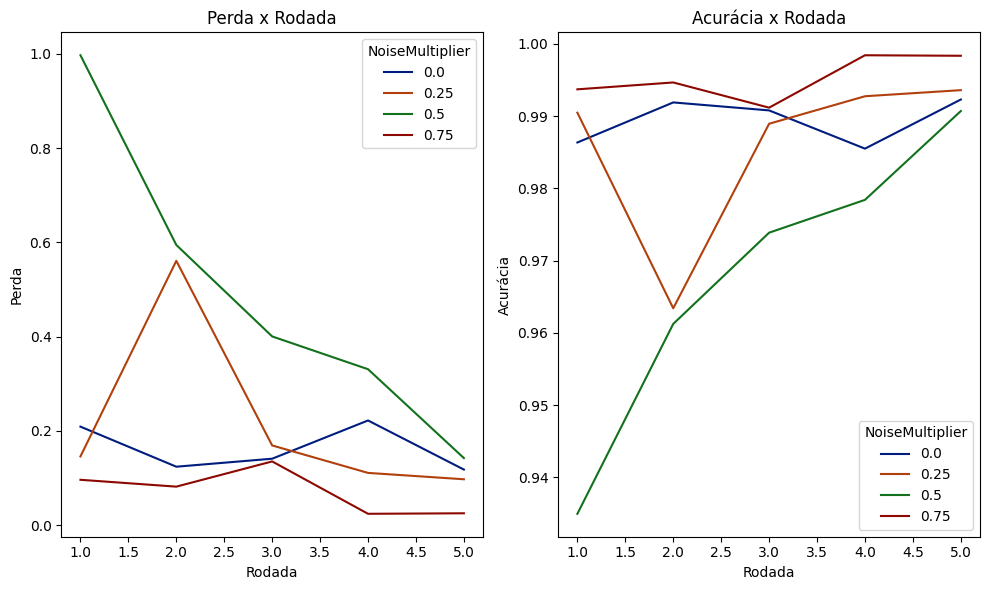

In [ ]:
plot_graph(metrics_df)

In [ ]:
# F1 Score, Recall, Acurácia, Tempo de execução

In [ ]:
# Métricas de privacidade (differential privacy)